In [1]:
from google.colab import drive
drive.mount('/content/drive')

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

true_path = '/content/drive/MyDrive/Fakenewsnet/BuzzFeed_real_news_content.csv'
fake_path = '/content/drive/MyDrive/Fakenewsnet/BuzzFeed_fake_news_content.csv'

true_df = pd.read_csv(true_path)
fake_df = pd.read_csv(fake_path)

true_df['label'] = 1
fake_df['label'] = 0

df = pd.concat([true_df, fake_df])



Mounted at /content/drive


,title,label
0,Chelsea Handler Gets The Last Word After RNC C...,1
1,Proof The Mainstream Media Is Manipulating The...,0
2,Website is Down For Maintenance,0
3,Tebow DISMANTLES national anthem protests in o...,0
4,Is Hillary in a No-Win Situation?,1
...,...,...
177,"SICK! Muslim Refugee Beats, Urinates On Pregna...",0
178,Dem congressman to IRS: Audit the Trump Founda...,1
179,BOOM! Charlotte Officials FINALLY Silence Riot...,0
180,BREAKING: Judge DEMANDS Release Of Clinton’s S...,0


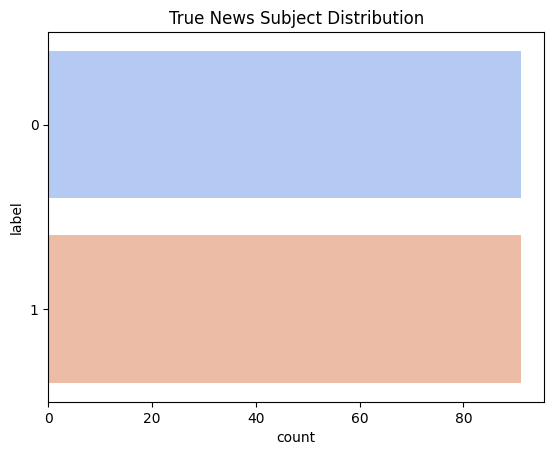

In [2]:
from sklearn.utils import shuffle

df = df[['title','label']]

# Shuffle
df = shuffle(df).reset_index(drop=True)

display(df)
sns.countplot(y="label", palette="coolwarm", data=df).set_title('True News Subject Distribution')
plt.show()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   182 non-null    object
 1   label   182 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.0+ KB


In [4]:
df.drop_duplicates(subset=['title'],keep='first',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 0 to 181
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   178 non-null    object
 1   label   178 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.2+ KB


In [5]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import re
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
list_of_words = []

for title in df['title'].dropna():
    title = re.sub(r'http\S+', '', title)
    title = re.sub(r'www\S+', '', title)
    word = re.sub('[^a-zA-Z]', ' ', title)
    word = word.lower()
    word = word.split()
    word = [lemmatizer.lemmatize(w) for w in word if not w in stop_words]
    word = ' '.join(word)
    list_of_words.append(word)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [6]:
unique_words = list(set(word for sentence in list_of_words for word in sentence.split()))
voc_size = len(unique_words)

In [7]:
titles = [text for text in list_of_words]

max_len = 0
titles_len = []
for title in titles:
    titles_len.append(len(title.split()))
    max_len = max(len(title.split()), max_len)

print('Number of titles:', len(titles))
print('Max length of the titles:', max_len)
print('Mean length of the titles:', np.mean(titles_len))
print('Median length of the titles:', np.median(titles_len))

Number of titles: 178
Max length of the titles: 16
Mean length of the titles: 7.820224719101123
Median length of the titles: 8.0


In [8]:
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Creating A Tokenizer To Tokenize The Words And Create Sequences Of Tokenized Words

tokenizer = Tokenizer(num_words = voc_size)
tokenizer.fit_on_texts(list_of_words)

sequences = tokenizer.texts_to_sequences(list_of_words)
padded_df = pad_sequences(sequences,maxlen = max_len, padding = 'pre', truncating = 'post')


# **LSTM**

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout, BatchNormalization, SpatialDropout1D
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.regularizers import l2
## Creating model Using LSTM
l2_reg = 0.001
optimizer = Adam(lr=0.001)
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=max_len))
model.add(Dropout(0.3))
# model.add(LSTM(100))
model.add(LSTM(100, kernel_regularizer=l2(l2_reg), recurrent_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])



/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [10]:
from sklearn.model_selection import train_test_split
z =np.array(padded_df)
y =np.array(df['label'])
x_train, x_test, y_train, y_test = train_test_split(z, y, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=42)


In [11]:
# upsampling and shuffle
import numpy as np
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
x_train, y_train = ros.fit_resample(x_train, y_train)
x_val, y_val = ros.fit_resample(x_val, y_val)
x_train, y_train = shuffle(x_train, y_train, random_state=42)
x_val, y_val = shuffle(x_val, y_val, random_state=42)

Epoch 1/10
2/2 [==============================] - 9s 728ms/step - loss: 0.9630 - accuracy: 0.5242 - val_loss: 0.9551 - val_accuracy: 0.7273
Epoch 2/10
2/2 [==============================] - 0s 31ms/step - loss: 0.9520 - accuracy: 0.6532 - val_loss: 0.9442 - val_accuracy: 0.8182
Epoch 3/10
2/2 [==============================] - 0s 31ms/step - loss: 0.9404 - accuracy: 0.7016 - val_loss: 0.9336 - val_accuracy: 0.8636
Epoch 4/10
2/2 [==============================] - 0s 34ms/step - loss: 0.9304 - accuracy: 0.7177 - val_loss: 0.9230 - val_accuracy: 0.8182
Epoch 5/10
2/2 [==============================] - 0s 32ms/step - loss: 0.9191 - accuracy: 0.6774 - val_loss: 0.9124 - val_accuracy: 0.8182
Epoch 6/10
2/2 [==============================] - 0s 31ms/step - loss: 0.9071 - accuracy: 0.7419 - val_loss: 0.9016 - val_accuracy: 0.8636
Epoch 7/10
2/2 [==============================] - 0s 32ms/step - loss: 0.8961 - accuracy: 0.7742 - val_loss: 0.8904 - val_accuracy: 0.8636
Epoch 8/10
2/2 [==========

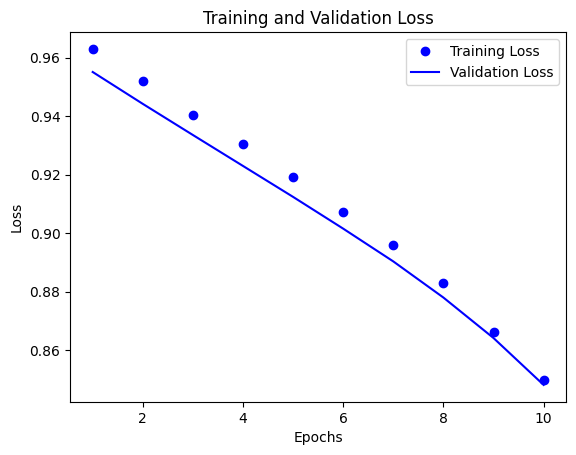

In [12]:
import time

# Training the model
start_time = time.time()
history = model.fit(x_train, y_train, batch_size = 64, validation_data=(x_val, y_val), epochs = 10)
end_time = time.time()
training_time = end_time - start_time
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss)+1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 [==============================] - 0s 4ms/step
LSTM Model Accuracy :  0.6388888888888888
Precision :  0.5806451612903226
Recall :  1.0
F1 :  0.7346938775510204
G-mean: 0.5270462766947299
Training time:  9.18164610862732
Inference time:  0.4389913082122803
              precision    recall  f1-score   support

           0       1.00      0.28      0.43        18
           1       0.58      1.00      0.73        18

    accuracy                           0.64        36
   macro avg       0.79      0.64      0.58        36
weighted avg       0.79      0.64      0.58        36



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


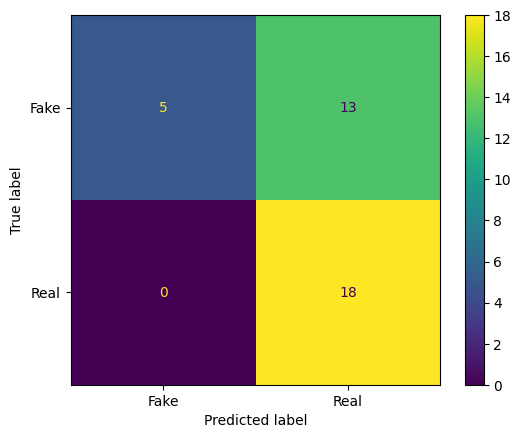

In [13]:
# Making prediction
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report,accuracy_score
from scipy.stats import gmean
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
start_time = time.time()
prediction=(model.predict(x_test) > 0.5).astype("int32")
end_time = time.time()
inference_time = end_time - start_time
accuracy = accuracy_score(list(y_test), prediction)
cm = confusion_matrix(list(y_test), prediction)
g_mean = geometric_mean_score(y_test, prediction)
print("LSTM Model Accuracy : ", accuracy)
print("Precision : ", precision_score(list(y_test), prediction))
print("Recall : ", recall_score(list(y_test), prediction))
print("F1 : ", f1_score(list(y_test), prediction))
print("G-mean:", g_mean)
print("Training time: ", training_time)
print("Inference time: ", inference_time)
print(classification_report(y_test, prediction))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','Real'])
disp.plot()